In [1]:
# Import necessary libraries

import pickle as pkl
import matplotlib.pyplot as plt  
import numpy as np

import problem_unittests as tests


%matplotlib inline

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
from torch.utils.data import Dataset, DataLoader

def get_dataloader(batch_size, image_size, data_dir):

    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
        
    :return: DataLoader with batched data
    """
    # TODO: Implement function and return a dataloader
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 32x32
                                    transforms.ToTensor()])
    
    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(data_dir, transform)

    # create and return DataLoaders
    data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return data_loader

In [4]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [5]:
# Define the model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                    kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
  
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)  

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        
         # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


tests.test_discriminator(Discriminator)

Tests Passed


In [12]:

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        
        # define feedforward behavior
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out


tests.test_generator(Generator)

Tests Passed


In [14]:
from torch.nn import init

def weights_init_normal(m):
    
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    init_type='normal'
    init_gain=0.02

    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

In [15]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [16]:
def real_loss(D_out, smooth=True):
    
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [47]:
def train(D, G,train_data_loader, n_epochs, print_every=50):
    
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_data_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()

            # 1-1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # 1-2. Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # 2-1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [25]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [18]:
# Train the model for biased dataset

In [23]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


In [19]:
batch_size = 32
img_size = 32
data_dir='processed_celeba_small/celeba'

celeba_train_loader = get_dataloader(batch_size, img_size,data_dir)

In [20]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [21]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
# params
lr = 0.001
beta1=0.1
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [24]:
# set number of epochs 
n_epochs = 50


# call training function
losses = train(D, G, celeba_train_loader,n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.5995 | g_loss: 1.5152
Epoch [    1/   50] | d_loss: 1.6936 | g_loss: 2.6978
Epoch [    1/   50] | d_loss: 1.3426 | g_loss: 1.2748
Epoch [    1/   50] | d_loss: 1.3727 | g_loss: 1.1920
Epoch [    1/   50] | d_loss: 1.6337 | g_loss: 2.4025
Epoch [    1/   50] | d_loss: 1.5218 | g_loss: 1.8484
Epoch [    1/   50] | d_loss: 1.4723 | g_loss: 1.5773
Epoch [    1/   50] | d_loss: 1.2790 | g_loss: 1.1284
Epoch [    1/   50] | d_loss: 1.3109 | g_loss: 1.0805
Epoch [    1/   50] | d_loss: 1.4959 | g_loss: 0.6131
Epoch [    1/   50] | d_loss: 1.2256 | g_loss: 1.5130
Epoch [    1/   50] | d_loss: 1.3266 | g_loss: 1.3763
Epoch [    1/   50] | d_loss: 1.3328 | g_loss: 1.0553
Epoch [    1/   50] | d_loss: 1.3079 | g_loss: 0.7354
Epoch [    1/   50] | d_loss: 1.2657 | g_loss: 1.0961
Epoch [    1/   50] | d_loss: 1.3008 | g_loss: 0.8023
Epoch [    1/   50] | d_loss: 1.5185 | g_loss: 0.7563
Epoch [    1/   50] | d_loss: 1.3407 | g_loss: 0.9351
Epoch [    1/   50] | d_loss

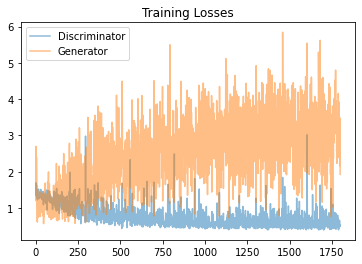

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

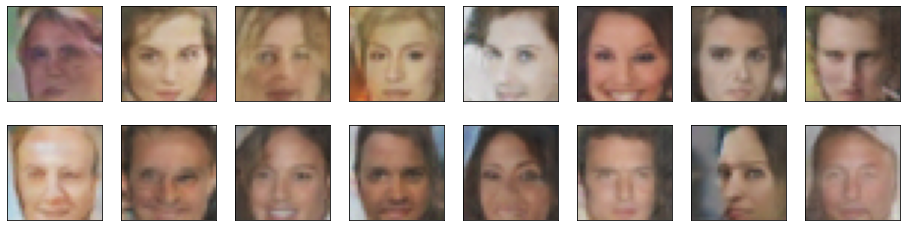

In [28]:
_ = view_samples(-1, samples)

In [42]:
# Train the model based on unbiased dataset

In [57]:
batch_size = 32
img_size = 32
data_dir='fairface/fairface-img-margin025-trainval/'

fairface_train_loader = get_dataloader(batch_size, img_size,data_dir)

In [58]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [59]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
# params
lr = 0.001
beta1=0.1
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [60]:
# set number of epochs 
n_epochs = 50


# call training function
losses = train(D, G,fairface_train_loader, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3746 | g_loss: 1.5896
Epoch [    1/   50] | d_loss: 1.2299 | g_loss: 1.8357
Epoch [    1/   50] | d_loss: 1.2094 | g_loss: 0.9691
Epoch [    1/   50] | d_loss: 1.3497 | g_loss: 0.8368
Epoch [    1/   50] | d_loss: 1.4141 | g_loss: 0.9180
Epoch [    1/   50] | d_loss: 1.4187 | g_loss: 1.3252
Epoch [    1/   50] | d_loss: 1.4498 | g_loss: 1.6493
Epoch [    1/   50] | d_loss: 1.3674 | g_loss: 1.0770
Epoch [    1/   50] | d_loss: 1.5030 | g_loss: 1.1148
Epoch [    1/   50] | d_loss: 1.3787 | g_loss: 1.0733
Epoch [    1/   50] | d_loss: 1.2644 | g_loss: 0.7887
Epoch [    1/   50] | d_loss: 1.3847 | g_loss: 1.0065
Epoch [    1/   50] | d_loss: 1.3460 | g_loss: 1.0074
Epoch [    1/   50] | d_loss: 1.4541 | g_loss: 0.9477
Epoch [    1/   50] | d_loss: 1.3276 | g_loss: 0.7708
Epoch [    1/   50] | d_loss: 1.3368 | g_loss: 1.3733
Epoch [    1/   50] | d_loss: 1.3737 | g_loss: 0.9650
Epoch [    1/   50] | d_loss: 1.4573 | g_loss: 0.6249
Epoch [    1/   50] | d_loss

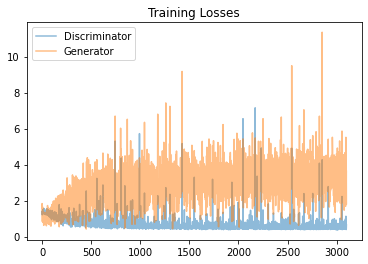

In [61]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [62]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

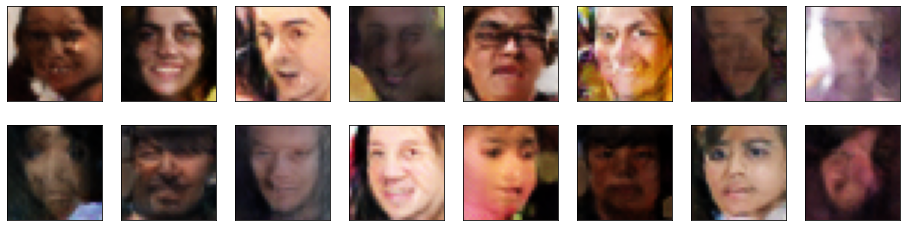

In [63]:
_ = view_samples(-1, samples)

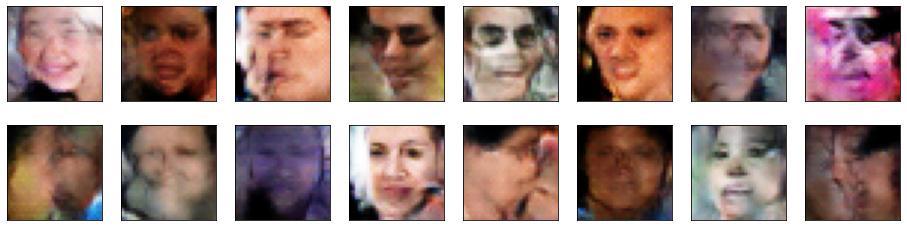

In [64]:
_ = view_samples(1, samples)

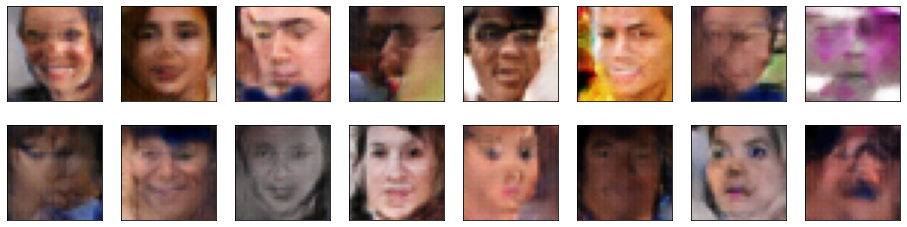

In [65]:
_ = view_samples(10, samples)

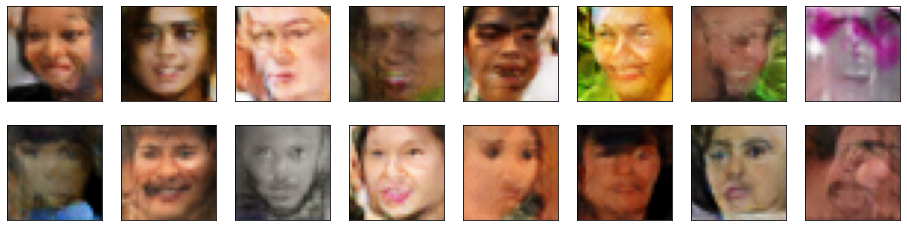

In [66]:
_ = view_samples(20, samples)

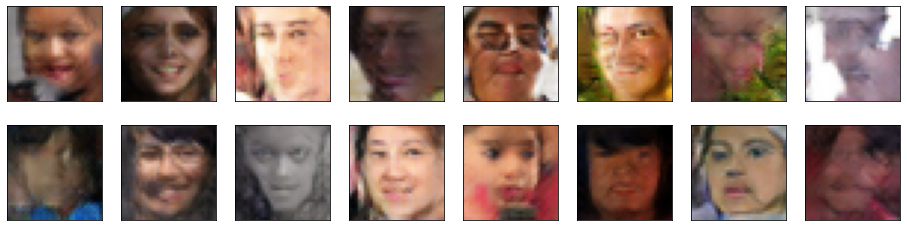

In [67]:
_ = view_samples(30, samples)

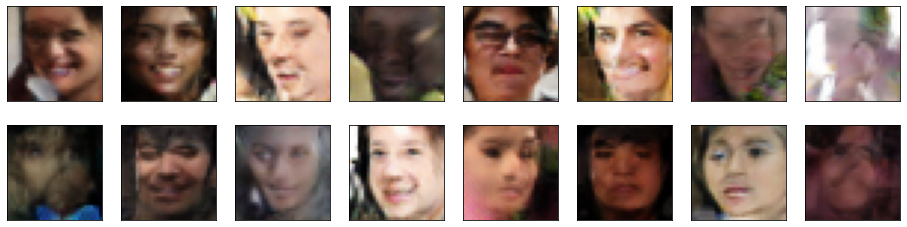

In [68]:
_ = view_samples(40, samples)